In [1]:
# import standard modules and DCTR
import os
os.system('for a in /sys/bus/pci/devices/*; do echo 0 | tee -a $a/numa_node>/dev/null; done') # get rid of NUMA node warnings: https://github.com/tensorflow/tensorflow/issues/42738
os.system('nvidia-smi') # make sure nvidia gpu acceleration is working

import sys
import numpy as np
import math
import tensorflow as tf 


tf.compat.v1.logging.set_verbosity('ERROR') # get rid of some warnings that don't impact anything
# make sure GPU usage is enabled
print(tf.config.list_physical_devices('GPU'))

# import DCTR
import DCTR


Wed Mar 20 10:55:00 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:09:00.0  On |                  N/A |
|  0%   51C    P5    32W / 250W |   7337MiB /  8192MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# load data

In [2]:
data_dir = './Data'


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
x0_plt = []
x0_plt = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_converted_lhe.npz', i=3)[:int(3e7)]
print('POWHEG hvq all particles x0_plt.shape: '+str(x0_plt.shape))

x0_plt_nrm = []
x0_plt_nrm = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_normed_converted_lhe.npz', i=3)[:int(3e7)]
print('POWHEG hvq all particles x0_plt_nrm.shape: '+str(x0_plt_nrm.shape))



POWHEG hvq all particles x0_plt.shape: (30000000, 3, 9)
POWHEG hvq all particles x0_plt_nrm.shape: (30000000, 3, 9)


In [4]:
# MiNNLO
# plotting data
x1_plt = []
x1_plt = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_13TeV_NLO/converted_lhe.npz', i=3)
print('MiNNLO all particles x1_plt.shape: '+str(x1_plt.shape))


MiNNLO all particles x1_plt.shape: (9553938, 3, 9)


In [5]:
# get normalized event generator weights

x0_plt_wgt = x0_plt_nrm[:, 0, 7].copy()
x0_plt_wgt /= np.mean(x0_plt_wgt) 

x1_plt_wgt = x1_plt[:, 0, 7].copy()
x1_plt_wgt /= np.mean(x1_plt_wgt)


In [6]:
# delete energy
x0_plt_nrm = np.delete(x0_plt_nrm, 5, -1)

# delete eta
x0_plt_nrm = np.delete(x0_plt_nrm, 4, -1)


# Plot

In [7]:
model = './best_model.tf'

with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], x0_plt_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook



2024-03-20 11:03:44.579770: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 11:03:45.287571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 338 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-03-20 11:03:49.882056: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1800000000 exceeds 10% of free system memory.
2024-03-20 11:03:50.420266: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 240000000 exceeds 10% of free system memory.
2024-03-20 11:03:50.445465: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 240000000 ex

NNLO: mean: 61.623, std: 72.536, max/min: 1881.821853030107/0.001743452831167295 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 62.855, std: 73.022, max/min: 2757.005175485615/0.012179553537007322 
 Mean Absolute Error 24355.916603195892 
 Mean Relative Error 0.0461920175619661 
 reduced chi square of 515.8903791315377 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 61.788, std: 72.884, max/min: 2757.005175485615/0.012179553537007322 
 Mean Absolute Error 972.3600382259116 
 Mean Relative Error 0.01356936153024435 
 reduced chi square of 1.2620871782830005 with p 0.1567200604309846 
 compared to NNLO


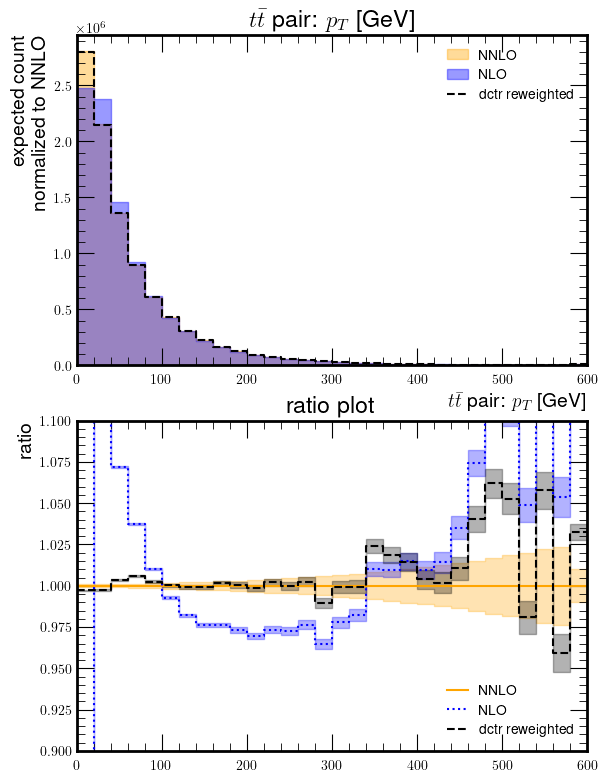

NNLO: mean: 523.184, std: 178.057, max/min: 5626.682794956003/322.9727283915917 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 521.922, std: 176.237, max/min: 5596.883653831986/203.75144644649072 
 Mean Absolute Error 3344.939500960116 
 Mean Relative Error 0.022815286223939777 
 reduced chi square of 12.26069300103826 with p 6.841368685558274e-58 
 compared to NNLO
dctr reweighted: mean: 524.453, std: 180.732, max/min: 5596.883653831986/203.75144644649072 
 Mean Absolute Error 1256.471315422035 
 Mean Relative Error 0.020931633189320564 
 reduced chi square of 4.043221906156318 with p 1.4305577323319032e-12 
 compared to NNLO


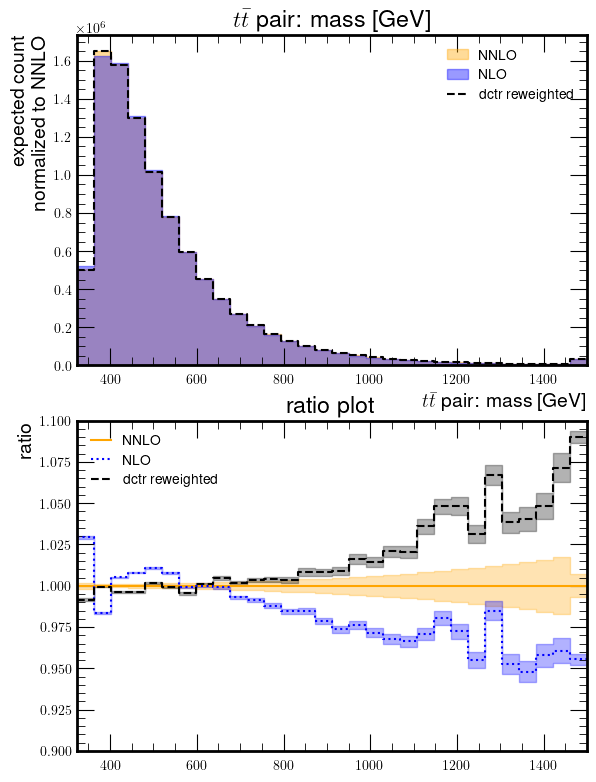

NNLO: mean: 0.001, std: 3.417, max/min: 13.830049878532156/-13.20077537478709 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 0.000, std: 3.291, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 17581.615783974044 
 Mean Relative Error 0.3227158442525543 
 reduced chi square of 699.2403322785747 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 0.003, std: 3.412, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 1461.2419221560297 
 Mean Relative Error 0.02455958165228367 
 reduced chi square of 2.233330081827237 with p 0.00015215466032190473 
 compared to NNLO


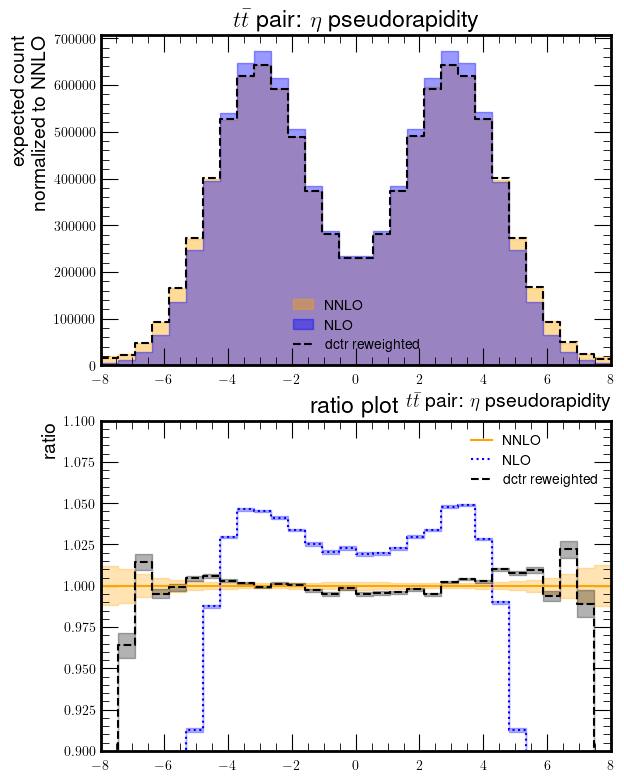

NNLO: mean: 862.694, std: 503.370, max/min: 6492.5814801/329.6132055 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 862.039, std: 505.648, max/min: 7187.152286/226.4245678 
 Mean Absolute Error 1065.1348960054763 
 Mean Relative Error 0.005103061361845667 
 reduced chi square of 1.1855245807859613 with p 0.2256145644851225 
 compared to NNLO
dctr reweighted: mean: 866.839, std: 509.520, max/min: 7187.152286/226.4245678 
 Mean Absolute Error 1792.1128376177162 
 Mean Relative Error 0.01276157982647419 
 reduced chi square of 3.7103559833295274 with p 5.74239014457415e-11 
 compared to NNLO


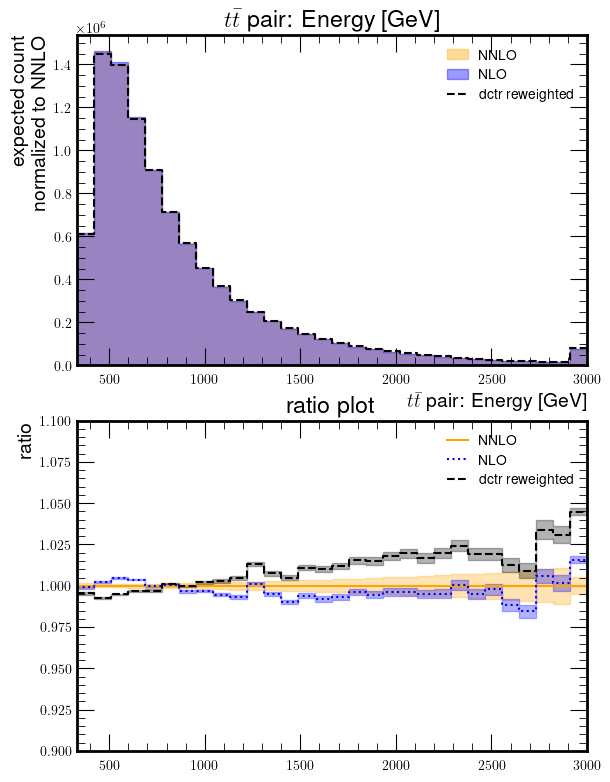

NNLO: mean: 120.981, std: 80.007, max/min: 2125.1621873385748/0.02517621005772228 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 122.735, std: 80.658, max/min: 2882.2696643478166/0.029502534939254157 
 Mean Absolute Error 6388.838675838955 
 Mean Relative Error 0.03470226231437661 
 reduced chi square of 42.908988539215805 with p 1.4270124370282426e-243 
 compared to NNLO
dctr reweighted: mean: 121.304, std: 80.552, max/min: 2882.2696643478166/0.029502534939254157 
 Mean Absolute Error 842.0283926332952 
 Mean Relative Error 0.014091236516833305 
 reduced chi square of 1.4986450059926735 with p 0.04125374239738771 
 compared to NNLO


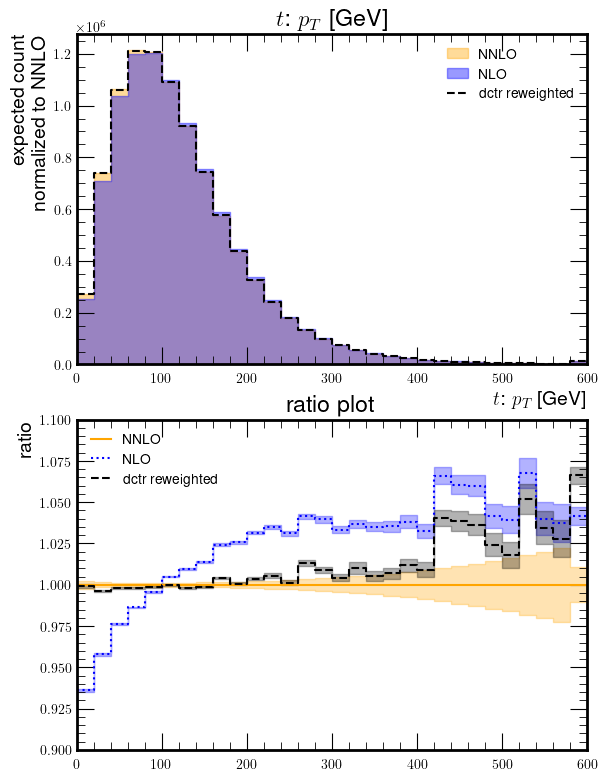

NNLO: mean: 172.341, std: 2.602, max/min: 185.5999802308967/159.40000608638425 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 171.937, std: 6.967, max/min: 243.95168778118295/80.40522855742726 
 Mean Absolute Error 21243.964195439323 
 Mean Relative Error 0.2603429771935189 
 reduced chi square of 3278.16561632731 with p 0.0 
 compared to NNLO
dctr reweighted: mean: 172.341, std: 2.608, max/min: 243.95168778118295/80.40522855742726 
 Mean Absolute Error 410.4939131879449 
 Mean Relative Error 0.006555851548910141 
 reduced chi square of 0.45108909338551423 with p 0.9957573545306053 
 compared to NNLO


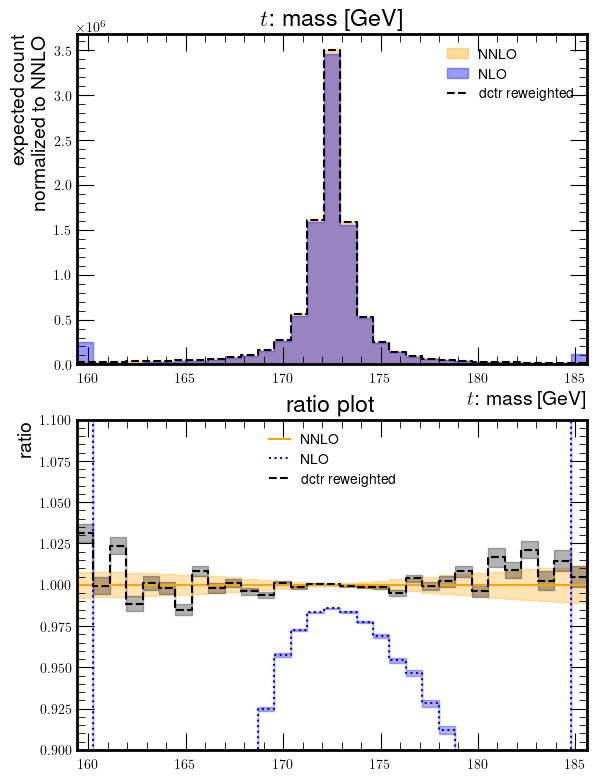

NNLO: mean: 0.001, std: 1.884, max/min: 9.769814493793154/-10.18823770968854 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 0.000, std: 1.866, max/min: 10.334972491799638/-9.973916160246644 
 Mean Absolute Error 4392.759537786609 
 Mean Relative Error 0.057047626096718304 
 reduced chi square of 20.69325261265014 with p 6.132143673496931e-108 
 compared to NNLO
dctr reweighted: mean: 0.001, std: 1.887, max/min: 10.334972491799638/-9.973916160246644 
 Mean Absolute Error 856.9109366152844 
 Mean Relative Error 0.037002380937337875 
 reduced chi square of 0.776774639624205 with p 0.7977543086531363 
 compared to NNLO


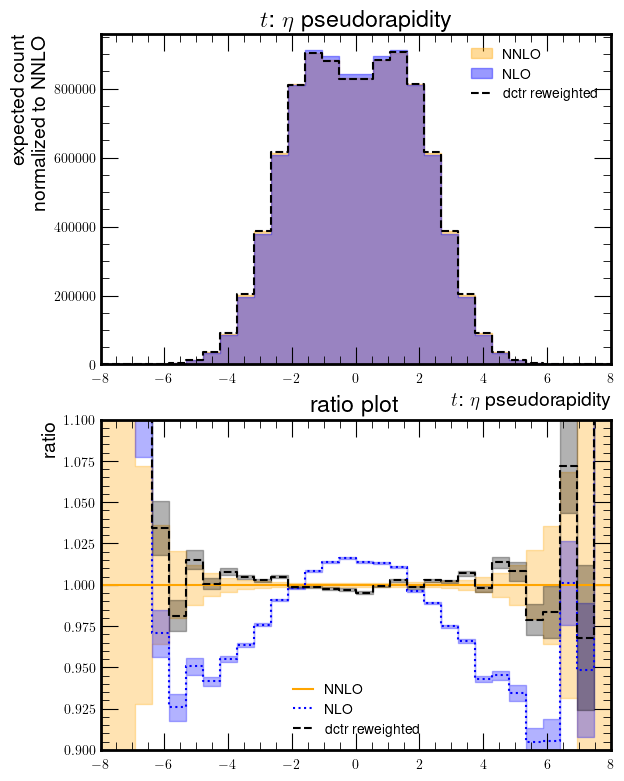

NNLO: mean: 432.960, std: 333.470, max/min: 5996.224969/159.6472363 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: mean: 432.197, std: 332.414, max/min: 6073.435866/82.10167673 
 Mean Absolute Error 1559.451024164345 
 Mean Relative Error 0.008574883761760802 
 reduced chi square of 2.313510263420938 with p 7.498327134056858e-05 
 compared to NNLO
dctr reweighted: mean: 434.970, std: 336.941, max/min: 6073.435866/82.10167673 
 Mean Absolute Error 1330.3492625122192 
 Mean Relative Error 0.011197175830602646 
 reduced chi square of 2.1597200854738983 with p 0.00028741642589707957 
 compared to NNLO


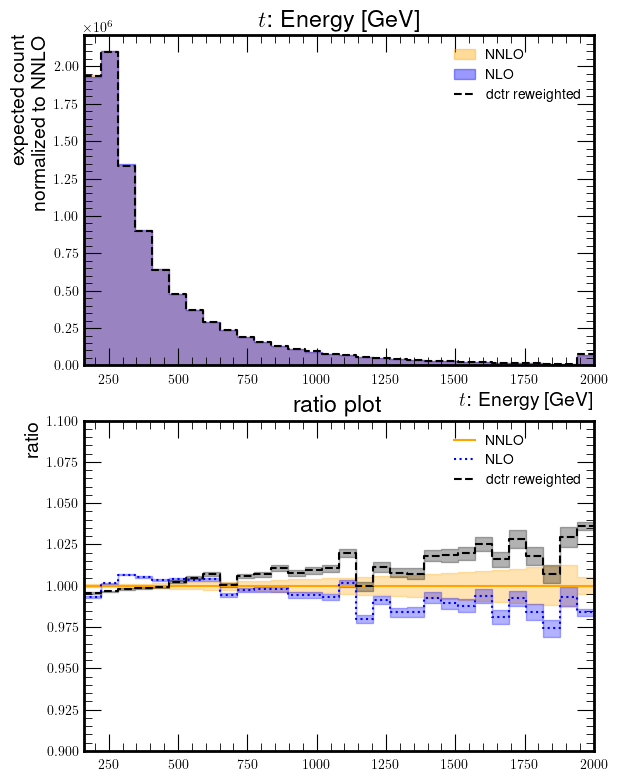

: mean: 2.646, std: 0.664, max/min: 3.1415926443988056/2.0450538809058116e-06 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to 
NLO: mean: 2.643, std: 0.660, max/min: 3.1415926462027195/5.15376617826746e-07 
 Mean Absolute Error 14268.229443807168 
 Mean Relative Error 0.01457292544935174 
 reduced chi square of 180.6130239655667 with p 0.0 
 compared to 
dctr reweighted: mean: 2.647, std: 0.665, max/min: 3.1415926462027195/5.15376617826746e-07 
 Mean Absolute Error 1874.4256072531182 
 Mean Relative Error 0.006712129805237055 
 reduced chi square of 2.588476605063765 with p 5.961959765898198e-06 
 compared to 


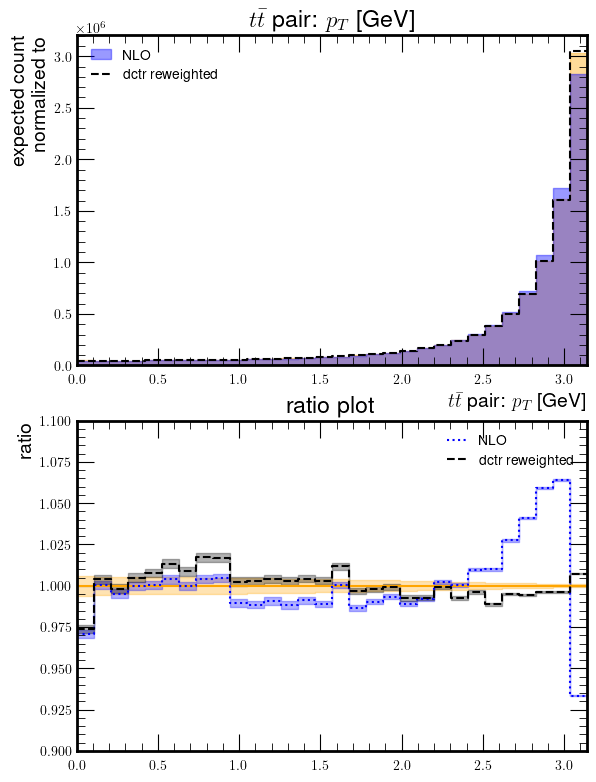

In [12]:
'''
plot_ratio() args:
args, arg_index = 0, part_index = 0, title = None, x_label = None, y_label = None, 
bins = None, start = None, stop = None, div = 35, ratio_ylim=[0.9,1.1],
figsize=(6,8), layout='rows', stats_only=False, y_scale=None, verbose = True
'''

# setup args for plotting
args = [(x1_plt, x1_plt_wgt, 'NNLO'),
        (x0_plt, x0_plt_wgt, 'NLO'),
        (x0_plt, dctr_rwgt[0], 'dctr reweighted')]


mae_all = []
chi2_all = []
p_all = []

arg_indices = [0, 3, 4, 5]
part_indices = [0, 1]

# plot with proper ranges set for each observable
for part_index in part_indices:
    for arg_index in arg_indices:
        div = 31
        if arg_index == 1:  # rapidity
            start = None
            stop = None
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = None
                stop = 1500
            else:
                start = None
                stop = None
                div = 32
        elif arg_index == 4:  # pseudorapidity
            start = -8
            stop = 8
        elif arg_index == 5: # energy
            if part_index == 0:  # tt-pair
                start = None
                stop = 3000
            else:
                start = None
                stop = 2000
        else:  # pt
            start = 0
            stop = 600
        
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args, arg_index=arg_index, part_index=part_index, start=start, stop=stop, div=div)
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)

# delta phi
x0_delta_phi = DCTR.delta_phi(x0_plt)
x1_delta_phi = DCTR.delta_phi(x1_plt)

args_delta_phi = [(x1_delta_phi, x1_plt_wgt, ''), 
                  (x0_delta_phi, x0_plt_wgt, 'NLO'),
                  (x0_delta_phi, dctr_rwgt[0], 'dctr reweighted')]


mae_list, chi2_list, p_list = DCTR.plot_ratio(args_delta_phi, start = 0, stop = math.pi, div=31)

mae_all = np.array(mae_all.append(mae_list))
chi2_all = np.array(chi2_all.append(chi2_list))
p_all = np.array(p_all.append(p_list))


